In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from scipy.integrate import simps

In [2]:
Omicron_New_Cases = pd.read_csv('Omicron_wave_Jan_May.csv',parse_dates=['date'],index_col= ['date'],)
NewCases = Omicron_New_Cases['new_cases'] 

In [3]:
np.size(NewCases)

119

In [4]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau = 0.8; tau2 = 0.8;
psi = 0.5; 
phi1, phi2 = 1/180, 1/180
h1= 0.0012; 
h2 = (1-0.74)*h1;
rho = 1/14; rhot =1/10; rhoh =1/10;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
a = 1/3  # fixed to be 3 days 
 

theta = 0.5 # parameter adjusting reduced perception risk (assumed)
delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)
alpha1, alpha2 = 0.5, 0.5  # parameters which shows to which information people are more concerned

Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
Fmax = 0.027; F10 = 0.0029; F20 = (0.9)*F10;
Tmax = 0.5; T10 = 0.03; T20 = 0.03    #Tmax is adjusted to have a good fit
#Tmax = 0.022; T10 = 0.014; #T10 = 0.0013; 


In [5]:
# Fitted parameters
k1=  0.51
beta1=  0.65
beta2=  0.39
xi=  0.99
d1 =0.000071; d2 = 0.000073;  

In [6]:
S1_dfe = pi/(F10 +mu); S2_dfe = (pi*phi1*F10)/((phi1+mu)*(F10+mu)*(F20+mu)); V1_dfe = (pi*F10)/((phi1+mu)*(F10 +mu));
V2_dfe = (pi*phi1*F10*F20)/(mu*(phi1+mu)*(F10+mu)*(F20+mu));
N_dfe = S1_dfe + S2_dfe + V1_dfe + V2_dfe;

C1 = (beta1*S1_dfe)/N_dfe;  C2 = (1/N_dfe)*(beta2*((1-eta2)*S2_dfe + (1-eta4)*V2_dfe) + beta1*(1-eta1)*V1_dfe);
M1 = (eps*(1-tau))/((mu +eps)*(mu+rho+xi*T10))
M2 = (eps*tau)/((mu +eps)*(d1+mu+rho+T10))
M3 = (eps*tau)/((mu +eps)*(d1+mu+rho+T20))
M4 = ( xi*(1-tau)*T10*eps*(d1+mu+rho+T10) + tau*T10*eps*(mu+rho+xi*T10))/((mu +eps)*(d1+mu+rho+T10)*(h1+mu+rhot)*(mu+rho+xi*T10))
M5 = tau*T20*eps/((mu +eps)*(d1+mu+rho+T20)*(h2+mu+rhot))
M6 = (eps*(1-tau))/((mu +eps)*(mu+rho+xi*T20))
M7 = xi*(1-tau)*eps*T20/((mu +eps)*(mu+rho+xi*T20)*(h2+mu+rhot))
R_e = C1*(psi*M1 + M2 + M3 + (1-delta)*(M4+M5)) + C2*(psi*M6 + (1-delta)*M7)
print('Reproduction number =', R_e)

Reproduction number = 0.1973149529700926


In [7]:
# Initial conditions
NN = 51815808
V2_0 = 2891 #int(0.87*Data_Omicron['new_vaccinations'].iloc[0])
V1_0 = 431; #int(0.13*Data_Omicron['new_vaccinations'].iloc[0])
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 #int(0.2*E2_0)
I2_0 = 282116  #int(0.8*E2_0)
IT2_0 = 17632 #int(0.87*NewCases.iloc[0])
E1_0 = 52694 #int(0.13*20*NewCases.iloc[0])  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 #int(0.2*E1_0)
I1_0 = 42155 #int(0.8*E1_0)
IT1_0 = 2634 #int(0.13*NewCases.iloc[0])
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15
MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)
S2_0 = 40000000 # 0.9*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S3_0 = 4365186 #0.1*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + H_0 + R_0)

In [8]:
x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

In [9]:
t = np.linspace(0,119,119)

In [10]:
def model_eq(x,t):
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, H, R, Dth, MV, MN  = x
    dx = np.zeros(18)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + H + R
    
    T1 = T10 + (Tmax -T10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(B*MN)/(1+B*MN) )
    F1 = F10 + (Fmax -F10)*(alpha1*(Dtilde*MV)/(1+Dtilde*MV) + (1-alpha1)*(Btilde*MN)/(1+Btilde*MN))
    
    T2 = T20 + (Tmax -T20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*B*MN)/(1+theta*B*MN) )
    F2 = F20 + (Fmax -F20)*(alpha2*(theta*Dtilde*MV)/(1+theta*Dtilde*MV) + (1-alpha2)*(theta*Btilde*MN)/(1+theta*Btilde*MN))
    
    L1 = beta1*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau)*eps*E1-xi*T1*A1-(rho+mu)*A1
    dx[8] = (1-tau)*eps*E2-xi*T2*A2-(rho+mu)*A2
    dx[9] = tau*eps*E1-T1*I1-(rho+d1+mu)*I1
    dx[10] = tau*eps*E2-T2*I2-(rho+d1+mu)*I2
    dx[11] = xi*T1*A1+T1*I1-(rhot+h1+mu)*I_T1
    dx[12] = xi*T2*A2+T2*I2-(rhot+h2+mu)*I_T2
    dx[13] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[14] = rho*(A1+A2+I1+I2)+rhot*(I_T1+I_T2)+rhoh*H-(phi2+mu)*R
    dx[15] = d1*(I1+I2)+d2*H
    dx[16] = a*(k1*((I_T1+I_T2+I1+I2+H)/NN)-MV)
    dx[17] = a*(k1*((H + d1*(I1 + I2) + d2*H)/NN)-MN)
    return dx

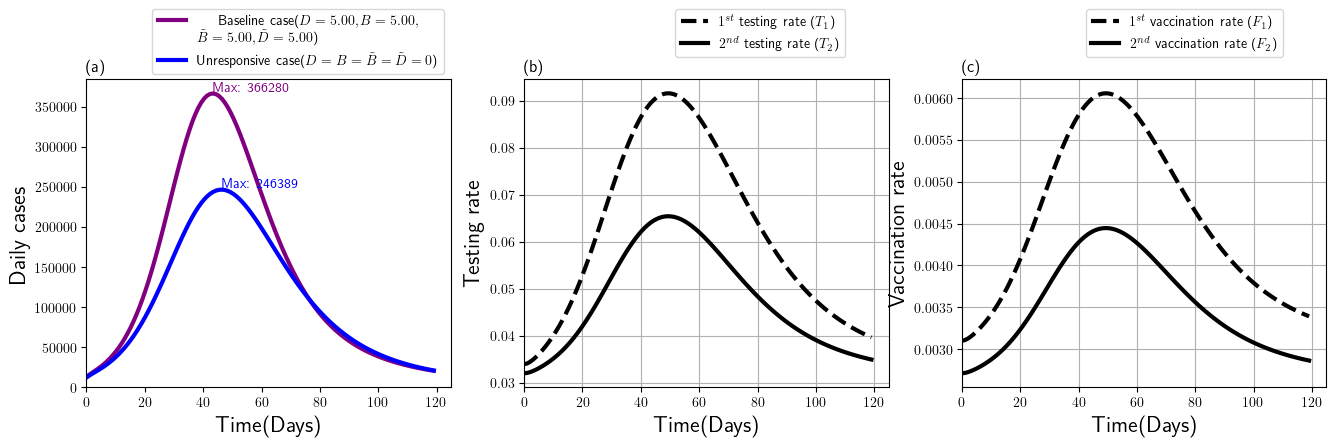

In [11]:
for i in [1,2]:
    Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
    D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
    
    if i ==1:
        D = 0 ; B = 0; Btilde =0;
        Dtilde = 0
        x = odeint(model_eq,x0,t)
        Total_cases1 = x[:,7] + x[:,8] + x[:,9] + x[:,10] + x[:,11] + x[:,12] + x[:,13]
        total_population = x[:,0] + x[:,1] + x[:,2] + x[:,3] +x[:,4] + x[:,5] + x[:,6] + x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13] + x[:,14]
        determined1 = x[:,11] + x[:,12]
        determined11 = np.divide(determined1,total_population)
        undetermined1 = x[:,7] + x[:,8] + x[:,9] + x[:,10]
        undetermined11 = np.divide(undetermined1,total_population)
        total_infected1 = determined1 + undetermined1;
        Daily_infected1 = eps*(x[:,5] + x[:,6])
        Vac2_1 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*Dtilde*x[:,16],(1+theta*Dtilde*x[:,16])) + (1-alpha2)* np.divide(theta*Btilde*x[:,17],(1+theta*Btilde*x[:,17])) )
        Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(D*x[:,16],(1+D*x[:,16])) + (1-alpha1)* np.divide(B*x[:,17],(1+B*x[:,17]))) 
        Test2_1 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*x[:,16],(1+theta*D*x[:,16])) + (1-alpha2)* np.divide(theta*B*x[:,17],(1+theta*B*x[:,17])))
        In1 = np.multiply(Test1_1,(xi*x[:,7]+ x[:,9])) + np.multiply(Test2_1,(xi*x[:,8]+ x[:,10]))
        In_undetected1 = x[:,11] + x[:,12] + x[:,13]
        vacc1 = x[:,3] +x[:,4]
        Max_Infected1 = max(x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13])
        Max_Hosp_Dead1 = max (x[:,13] +x[:,15])
        Max_In1 = max(In1)
        Area1 = simps(In1, t)                              
    
    elif i ==2:
        Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
        
        D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
        
        x = odeint(model_eq,x0,t)
        Total_cases2 =  x[:,7] + x[:,8] + x[:,9] + x[:,10] + x[:,11] + x[:,12] + x[:,13]
        total_population = x[:,0] + x[:,1] + x[:,2] + x[:,3] +x[:,4] + x[:,5] + x[:,6] + x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13] + x[:,14]
        determined2 = x[:,11] + x[:,12]
        Daily_infected2 = eps*(x[:,5] + x[:,6])
        determined22 = np.divide(determined2,total_population)
        undetermined2 = x[:,7] + x[:,8] + x[:,9] + x[:,10]
        undetermined22 = np.divide(undetermined2,total_population)
        total_infected2 = determined2 + undetermined2;
        Test1_4 = T10 + (Tmax -T10)*(alpha1* np.divide(D*x[:,16],(1+D*x[:,16])) + (1-alpha1)* np.divide(B*x[:,17],(1+B*x[:,17]))) 
        Vac1_4 = F10 + (Fmax -F10)*(alpha1* np.divide(Dtilde*x[:,16],(1+Dtilde*x[:,16])) + (1-alpha1)* np.divide(Btilde*x[:,17],(1+Btilde*x[:,17]))) 
        Test2_4 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*x[:,16],(1+theta*D*x[:,16])) + (1-alpha2)* np.divide(theta*B*x[:,17],(1+theta*B*x[:,17]))) 
        Vac2_4 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*Dtilde*x[:,16],(1+theta*Dtilde*x[:,16])) + (1-alpha2)* np.divide(theta*Btilde*x[:,17],(1+theta*Btilde*x[:,17])) ) 
        # Test1_1 = T10 + (Tmax -T10)*(np.divide(D*x[:,16],(1+D*x[:,16])))
        # Test2_1 = T20 + (Tmax -T20)*(np.divide(B*x[:,17],(1+B*x[:,17])))
        In4 = np.multiply(Test1_4,(xi*x[:,7]+ x[:,9])) + np.multiply(Test2_4,(xi*x[:,8]+ x[:,10]))
        In_undetected2 = x[:,11] + x[:,12] + x[:,13]
        vacc2 = x[:,3] +x[:,4]
        Max_Infected2 = max(x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13])
        Max_Hosp_Dead2 = max (x[:,13] +x[:,15])
        Max_In4 = max(In4)
        Max_T1 = max(Test1_4); Max_T2 = max(Test2_4); Max_V1 = max(Vac1_4);Max_V2 = max(Vac2_4);
        Final_In4 = In4[-1]
        Area4 = simps(In4, t)
fig, axs = plt.subplots(1,3,figsize=(16,4))
axs[0].plot(t,In4,label = fr'Baseline case($D ={D:.2f}, B ={B:.2f}, \\ \tilde B ={Btilde:.2f}, \tilde D={Dtilde:.2f}$)',color = 'purple', lw =3)
axs[0].plot(t,In1, label = r'Unresponsive case($D = B = \tilde{B} =\tilde{D} =0$)' , color = 'blue', lw = 3)
axs[0].text(t[np.argmax(In1)], Max_In1, f'Max: {Max_In1:.0f}', ha='left', va='bottom', color='blue')
axs[0].text(t[np.argmax(In4)], Max_In4, f'Max: {Max_In4:.0f}', ha='left', va='bottom', color='purple')
axs[0].set_xlim(left=0)
axs[0].set_ylim(bottom=0)
axs[0].set_xlabel('Time(Days)', fontsize=16)
axs[0].set_ylabel('Daily cases',fontsize=16)
axs[0].set_title('(a)', loc='left')
axs[0].legend(bbox_to_anchor= (1,1.25))

axs[1].plot(t,Test1_4,label = r'$1^{st}$ testing rate ($T_1$) ', color = 'black', lw =3,linestyle = '--')
axs[1].plot(t,Test2_4, label = r'$2^{nd}$ testing rate ($T_2$)', color = 'black', lw =3)
#axs[1].plot(t,Test2_1, label = fr'Unresponsive case($T_1 ={T10:.4f}, T_2 ={T20:.4f}$)',color = 'green', lw =3,linestyle = '--')
axs[1].set_xlabel('Time(Days)', fontsize=16)
axs[1].legend(bbox_to_anchor= (0.9,1.25))
axs[1].set_ylabel('Testing rate',fontsize=16)
axs[1].set_title('(b)', loc='left')
axs[1].set_xlim(left=0)
#axs[1].set_ylim(0,0.026)
axs[1].grid(True) 
#axs[1].legend()

axs[2].plot(t,Vac1_4,label = r'$1^{st}$ vaccination rate ($F_1$)', color = 'black', lw =3,linestyle = '--')
axs[2].plot(t,Vac2_4, label = r'$2^{nd}$ vaccination rate ($F_2$)', color = 'black', lw =3)
#axs[2].plot(t,Vac2_1, label = fr'Only mandatory case($F_1 ={F10:.4f}, F_2 ={F20:.4f}$)',color = 'green', lw =3,linestyle = '--')
axs[2].set_xlabel('Time(Days)', fontsize=16)
axs[2].legend(bbox_to_anchor= (0.9,1.25))
axs[2].set_ylabel('Vaccination rate',fontsize=16)
axs[2].set_title('(c)', loc='left')
axs[2].set_xlim(left=0)
#axs[2].set_ylim(0.00022,0.00024)
axs[2].grid(True) 
#axs[2].legend()
#plt.legend(loc = 'lower right')
# axs2 = fig.add_axes([0.5,0.5, 0.4,0.4])
# axs2.plot(t,In4,color = 'purple', lw =2)
# axs2.plot(t,In1,color = 'orange', lw =2)
# axs2.plot(t,In3,color = 'red', lw =2)
# axs2.set_xlim(left=0,right=500)
# axs2.set_ylim(bottom=0)

#plt.savefig('NEWCase2_Active_cases_dt_T1_T2_F1_F2.pdf',dpi=600, bbox_inches='tight')
#plt.tight_layout()
plt.show()
        


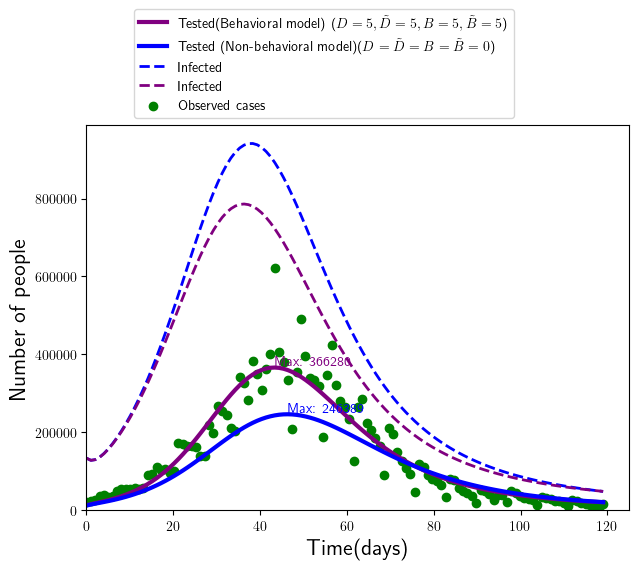

In [40]:
fig = plt.subplots(1,1,figsize=(7,5))
plt.plot(t,In4,label = fr'Tested(Behavioral model) ($D ={D:.0f},\tilde D={Dtilde:.0f}, B ={B:.0f}, \tilde B ={Btilde:.0f}$)',color = 'purple', lw =3)
plt.plot(t,In1, label = r'Tested (Non-behavioral model)($D =\tilde{D} = B =\tilde{B} =0$)' , color = 'blue', lw = 3)
plt.plot(t,Daily_infected1, color = 'blue', label = r'Infected',lw =2,linestyle = '--')
plt.plot(t,Daily_infected2, color = 'purple' , label = 'Infected',lw =2,linestyle = '--')
plt.scatter(t,NewCases, label = r'Observed cases', color = 'green')
plt.text(t[np.argmax(In1)], Max_In1, f'Max: {Max_In1:.0f}', ha='left', va='bottom', color='blue')
plt.text(t[np.argmax(In4)], Max_In4, f'Max: {Max_In4:.0f}', ha='left', va='bottom', color='purple')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Time(days)', fontsize=16)
plt.ylabel('Number of people',fontsize=16)
#plt.title('(a)', loc='left')
plt.legend(bbox_to_anchor = (0.8,1.32))
plt.savefig('NEWCase2_Active_cases_dt_T1_T2_F1_F2_New_BB_PPT.pdf',dpi=600, bbox_inches='tight')
plt.show()
#plt.legend(bbox_to_anchor= (0.6,1.25))



max_ratio_responsive = 0.45778896995964596
max_ratio_unresponsive = 0.3258093091350454


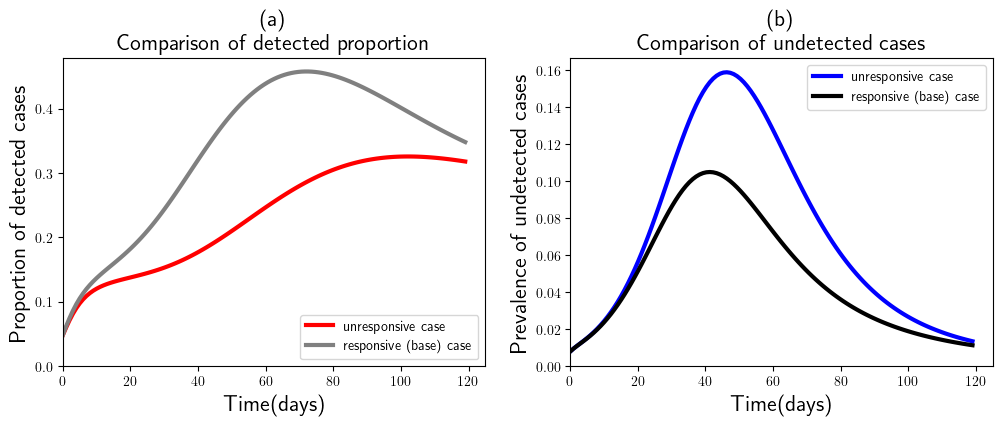

In [13]:
Ratio_unresponsive = np.divide(determined1,total_infected1)
Ratio_responsive = np.divide(determined2,total_infected2)
print('max_ratio_responsive =', max(Ratio_responsive))
print('max_ratio_unresponsive =', max(Ratio_unresponsive))
fig, axs = plt.subplots(1,2,figsize=(12,4))

axs[0].plot(t,Ratio_unresponsive,label = 'unresponsive case',color = 'r', lw =3)
axs[0].plot(t,Ratio_responsive,label = 'responsive (base) case',color = 'gray', lw =3)
axs[0].set_xlim(left=0)
axs[0].set_ylim(bottom=0)
axs[0].set_xlabel('Time(days)', fontsize=16)
axs[0].set_ylabel('Proportion of detected cases',fontsize=16)
axs[0].set_title('(a)\n Comparison of detected proportion',fontsize=16)
axs[0].legend() 
axs[1].plot(t,undetermined11,label = 'unresponsive case',color = 'blue', lw =3)
axs[1].plot(t,undetermined22,label = 'responsive (base) case',color = 'black', lw =3)
# axs[0].plot(t,determined22,label = 'Detected  in base case',color = 'green', lw =3)
# axs[0].plot(t,determined11,label = 'Deteted in unresponsive case',color = 'yellow', lw =3)
axs[1].set_xlim(left=0)
axs[1].set_ylim(bottom=0)
axs[1].set_xlabel('Time(days)', fontsize=16)
axs[1].set_ylabel('Prevalence of undetected cases',fontsize=16)
axs[1].set_title('(b)\n Comparison of undetected cases',fontsize=16)
axs[1].legend()

plt.savefig('percentage_of_detected_cases_New_BB.pdf',dpi=600, bbox_inches='tight')
plt.show()

In [14]:
Dtilde

5

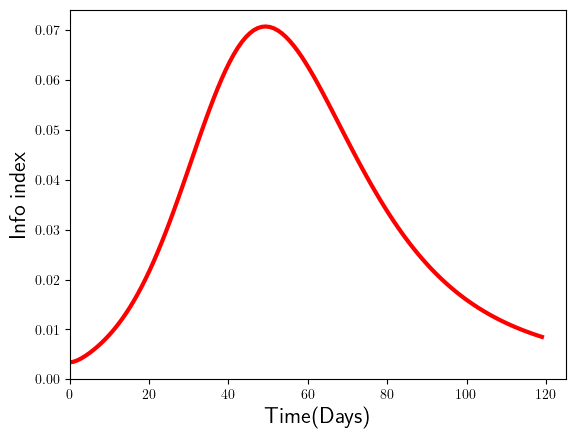

In [15]:
plt.plot(t,x[:,16],color = 'red', lw =3)
#plt.plot(t,x[:,17],legend = 'Info. severity',color = 'black', lw =3)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Time(Days)', fontsize=16)
plt.ylabel('Info index',fontsize=16)
plt.show()

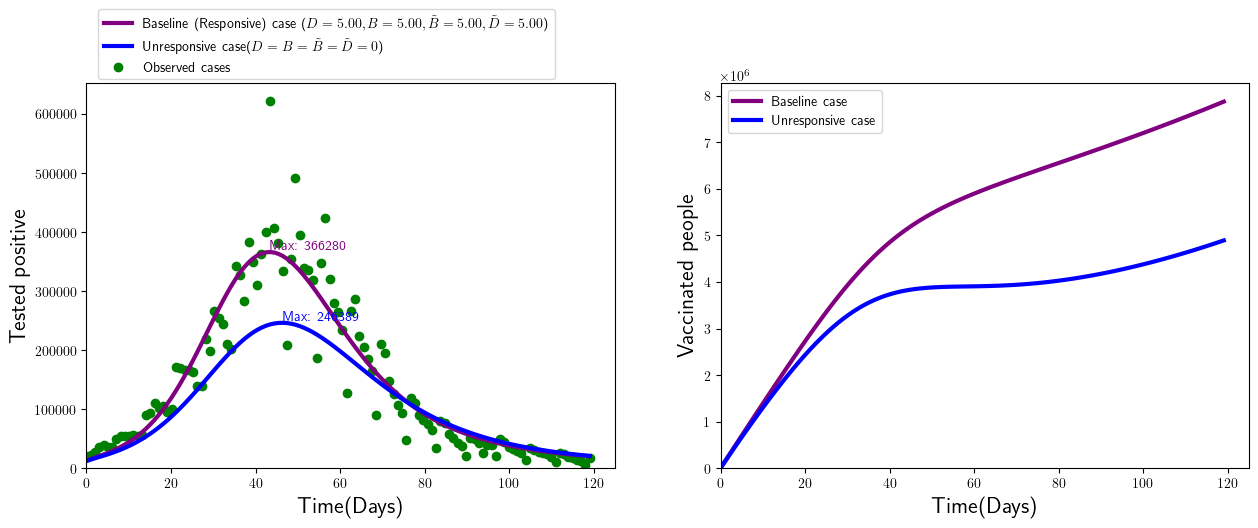

In [16]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(t,In4,label = fr'Baseline (Responsive) case ($D ={D:.2f}, B ={B:.2f}, \tilde B ={Btilde:.2f}, \tilde D={Dtilde:.2f}$)',color = 'purple', lw =3)
axs[0].plot(t,In1, label = r'Unresponsive case($D = B = \tilde{B} =\tilde{D} =0$)' , color = 'blue', lw = 3)
axs[0].scatter(t,NewCases, label = r'Observed cases', color = 'green')
axs[0].text(t[np.argmax(In1)], Max_In1, f'Max: {Max_In1:.0f}', ha='left', va='bottom', color='blue')
axs[0].text(t[np.argmax(In4)], Max_In4, f'Max: {Max_In4:.0f}', ha='left', va='bottom', color='purple')
axs[0].set_xlim(left=0)
axs[0].set_ylim(bottom=0)
axs[0].set_xlabel('Time(Days)', fontsize=16)
axs[0].set_ylabel('Tested positive',fontsize=16)
#plt.title('(a)', loc='left')
axs[0].legend(bbox_to_anchor = (0.9,1.21))


axs[1].plot(t,vacc2, lw=3, color = 'purple', label = 'Baseline case')
axs[1].plot(t,vacc1, lw=3, color = 'blue', label = 'Unresponsive case')
axs[1].set_xlim(left=0)
axs[1].set_ylim(bottom=0)
axs[1].set_xlabel('Time(Days)', fontsize=16)
axs[1].set_ylabel('Vaccinated people',fontsize=16)

axs[1].legend()
#plt.savefig('NEWCase2_vacc_dt_T1_T2_F1_F2.png',dpi=600, bbox_inches='tight')
plt.show()
#plt.legend(bbox_to_anchor= (0.6,1.25))

In [17]:
print('max of T1 =', Max_T1)
print('max of T2 =', Max_T2)
print('max of V1 =', Max_V1)
print('max of V2 =', Max_V2)
print('Arg max V2=', t[np.argmax(Test2_4)])
print('Arg max V2=', t[np.argmax(Vac2_4)])
print('Maximum total infected Case1', Max_Infected1)
print('Maximum hospitalized and dead Case1', Max_Hosp_Dead1)
print('Maximum total infected Case2', Max_Infected2)
print('Maximum hospitalized and dead Case2', Max_Hosp_Dead2)

max of T1 = 0.09156163008723983
max of T2 = 0.0653978529600967
max of V1 = 0.006056670819366979
max of V2 = 0.004446922624886721
Arg max V2= 49.41525423728813
Arg max V2= 49.41525423728813
Maximum total infected Case1 10287860.194908243
Maximum hospitalized and dead Case1 29060.913035003847
Maximum total infected Case2 8332217.8944129385
Maximum hospitalized and dead Case2 26226.47005533079


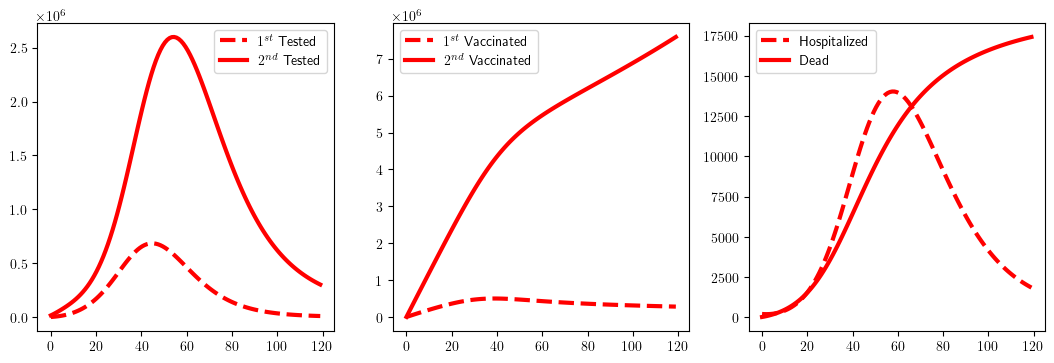

In [18]:
fig, axs = plt.subplots(1,3,figsize=(13,4))
#axhline(y=0.5, color='r', linestyle='-')
axs[0].plot(t,x[:,11],label =r'$1^{st}$ Tested' ,color = 'red',lw =3,linestyle = '--')
axs[0].plot(t,x[:,12],label =r'$2^{nd}$ Tested', color = 'red', lw =3)
axs[0].legend()
axs[1].plot(t,x[:,3],label =r'$1^{st}$ Vaccinated', color = 'red',lw =3,linestyle = '--')
axs[1].plot(t,x[:,4],label =r'$2^{nd}$ Vaccinated',color = 'red', lw =3)
axs[1].legend()
axs[2].plot(t,x[:,13],label ='Hospitalized',color = 'red',lw =3,linestyle = '--')
axs[2].plot(t,x[:,15],label ='Dead',color = 'red', lw =3)
axs[2].legend()
# axs[2].axhline(y=F10,color = 'red',lw =3,linestyle = '--')
# axs[2].plot(t,Vac1,color = 'black', lw =3)
# axs[3].axhline(y=F20,color = 'red',lw =3,linestyle = '--')
# axs[3].plot(t,Vac2,color = 'black', lw =3,linestyle = '--')